# Stimulus-Evoked Activity under *in vivo*-like conditions

In [1]:
import numpy as np
from scipy.stats import sem

from cell_template import BRANCH_COLORS
from parallel import Parallel

import sys
sys.path.append('../..')
import plot_tools as pt
import matplotlib.pylab as plt

# Protocol Description

- synapses splitted in excitatory (80%) and inhibitory (20%) categories
- background excitatory+inhibitory synaptic events at a given frequency (events through Poisson process)
- stimulus events: a set of synaptic events randomly picked within the excitatory population
- stimulus stength variable: **$n_{syn}$** the number of randomly picked synapses
- simulations on a per branch basis -- considering only the synapses of a given branch -- performing simulations on each branch
- firing response in Hz measured in [0,100]ms window following the stimulus

### Example Simulation
Run the below example with:
```
python stim_on_background.py --test -c Martinotti --nCluster 5 15 25 35 45 --bgStimFreq 1e-3 --bgFreqInhFactor 1 --nStimRepeat 2 --with_presynaptic_spikes
```

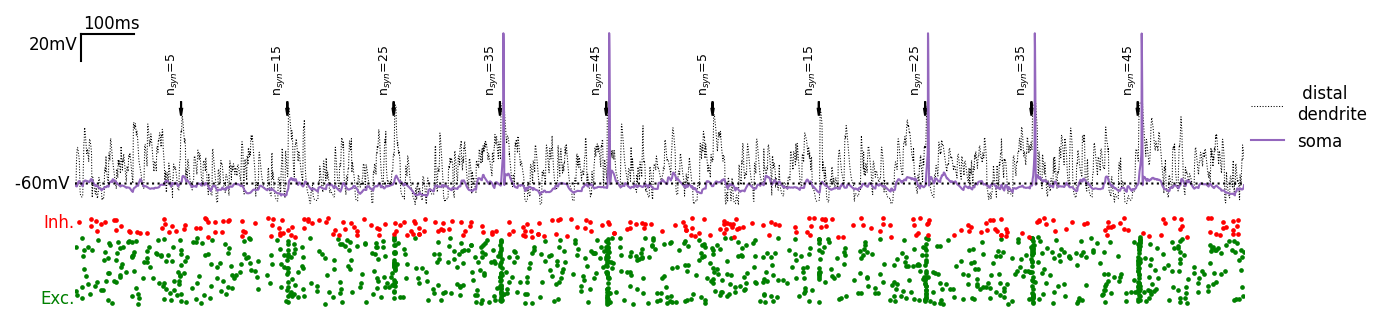

In [27]:
results = np.load('single_sim.npy', allow_pickle=True).item()

t = np.arange(len(results['Vm_soma']))*results['dt']
fig, AX = pt.figure(axes_extents=[[(1,2)],[(1,1)]],
                    figsize=(3,1), left=0, bottom=0., hspace=0.)
for r in range(int(results['nStimRepeat'])):
    for c, nC in enumerate(results['nCluster']):
        tstart = results['t0']+r*len(results['nCluster'])*results['ISI']+c*results['ISI']
        pt.arrow(AX[0], [tstart, 0, 0, -10],
                 head_width=4, head_length=5, width=0.1)
        pt.annotate(AX[0], 'n$_{syn}$=%i' % nC, (tstart, 5), 
                    rotation=90, xycoords='data', fontsize=6, ha='right')
AX[0].plot(t, results['Vm_dend'], 'k:', lw=0.5, label=' distal\ndendrite')
AX[0].plot(t, results['Vm_soma'], 'tab:purple', label='soma')
AX[0].plot(t, -60+0*t, 'k:')
pt.annotate(AX[0], '-60mV ', (0,-60), xycoords='data', ha='right', va='center')
pt.draw_bar_scales(AX[0], Xbar=100, Xbar_label='100ms', Ybar=20, Ybar_label='20mV')
AX[0].legend(frameon=False, loc=(1, 0.3))
for i, events in enumerate(results['presynaptic_exc_events']):
    AX[1].plot(events, i*np.ones(len(events)), '.', color='g')
for i, events in enumerate(results['presynaptic_inh_events']):
    AX[1].plot(events, len(results['presynaptic_exc_events'])+i*np.ones(len(events)), '.', 
               color='r')
pt.annotate(AX[1], 'Inh.', (0,1), ha='right', va='top', color='r')
pt.annotate(AX[1], 'Exc.', (0,0), ha='right', va='bottom', color='g')

pt.set_common_xlims(AX, lims=[t[0], t[-1]])
for ax in AX:
    ax.axis('off')

### Functions to Load and Analyze the Simulation Data

In [18]:
def load_params_from(sim):
    p = {}
    for k in ['dt', 'nStimRepeat', 'ISI', 't0']:
        p[k] = sim.fetch_quantity_on_grid(k, dtype=float, return_last=True) 
    p['nCluster'] = sim.fetch_quantity_on_grid('nCluster', dtype=object, return_last=True)
    return p

def show_Vm_trace(sim, 
                  loc='soma',
                  iBranch=0, 
                  varied_key = 'with_NMDA',
                  plot = {'with-NMDA':{'varied_key':True,
                                       'color':'tab:orange',
                                       'lw':1.0},
                          'without':{'varied_key':False,
                                    'color':'tab:grey',
                                    'lw':0.5}},
                  zoom=None):
    
    sim.fetch_quantity_on_grid('Vm_%s' % loc, dtype=object) 
    p = load_params_from(sim)
    
    params = dict(iBranch=iBranch)

    fig, ax = pt.figure(figsize=(2.5,2), left=0.2, bottom=0.5)

    Vms = {}
    for label in plot:
        params[varied_key] = plot[label]['varied_key']
        Vm = sim.get('Vm_%s' % loc, params)[0]
        t = np.arange(len(Vm))*p['dt']
        if zoom is not None:
            Vm = Vm[(t>zoom[0]) & (t<zoom[1])]
            t = t[(t>zoom[0]) & (t<zoom[1])]
        else:
            zoom=[t[0], t[-1]]
        ax.plot(t, Vm, label=label, color=plot[label]['color'], lw=plot[label]['lw'])

    for r in range(int(p['nStimRepeat'])):
        for c, nC in enumerate(p['nCluster']):
            tstart = p['t0']+r*len(p['nCluster'])*p['ISI']+c*p['ISI']
            if (tstart>zoom[0]) and (tstart<zoom[1]):
                pt.arrow(ax, [tstart, 0, 0, -10],
                         head_width=4, head_length=5, width=0.1)
                pt.annotate(ax, 'n$_{syn}$=%i' % nC, (tstart, 5), 
                            rotation=90, xycoords='data', fontsize=6, ha='right')
            
    ax.axis('off')
    ax.legend(loc=(1,0.4), frameon=False)
    pt.draw_bar_scales(ax, Xbar=100, Xbar_label='100ms', Ybar=20, Ybar_label='20mV')

def extract_trials(sim, 
                  loc='soma',
                  varied_key = 'with_NMDA',
                  true_false_labels=['with-NMDA', 'without'],
                  pre=-30, post=150):
    """
    returns elements of shape:
               VMs     (nBranch, nStims, nStimRepeat, nTimeSamples)
               SPIKES  (nBranch, nStims, nStimRepeat, nTimeSamples)
    """
    sim.fetch_quantity_on_grid('Vm_%s' % loc, dtype=object) 
    p = load_params_from(sim)
    
    T = np.arange(int(pre/p['dt']), int(post/p['dt']))*p['dt']
    nBranch = len(np.unique(sim.iBranch))
    nStims = len(p['nCluster'])
    VMs, SPIKEs, RATEs = {}, {}, {}
    
    for l, label in enumerate(true_false_labels):
        VMs[label] = np.zeros((nBranch, nStims, int(p['nStimRepeat']), len(T)))
        SPIKEs[label] = np.zeros((nBranch, nStims, int(p['nStimRepeat']), len(T)), dtype=int)
        RATEs[label] = np.zeros((nBranch, nStims, int(p['nStimRepeat']), len(T)), dtype=float)
        
        for iBranch in np.unique(sim.iBranch):
            
            params = {varied_key:(label==true_false_labels[0]),
                      'iBranch':iBranch}

            Vm = sim.get('Vm_%s' % loc, params)[0]
            
            _, VMs[label][iBranch, :, :, :], SPIKEs[label][iBranch, :, :, :] = \
                    trial_alignement(Vm, p, pre=pre, post=post)
            RATEs[label][iBranch, :, :, :] = SPIKEs[label][iBranch, :, :, :]/p['dt']
            
    return T, VMs, SPIKEs, RATEs
    
def trial_alignement(Vm, p, 
                     spike_threshold=-20,
                     pre=-30, post=150):
    
    t = np.arange(len(Vm))*p['dt']
    T = np.arange(int(pre/p['dt']), int(post/p['dt']))*p['dt']
    VMs = np.zeros((len(p['nCluster']), int(p['nStimRepeat']), len(T)))
    SPIKEs = np.zeros((len(p['nCluster']), int(p['nStimRepeat']), len(T)), dtype=int)
    for r in range(int(p['nStimRepeat'])):
        for c, nC in enumerate(p['nCluster']):
            tstart = p['t0']+r*len(p['nCluster'])*p['ISI']+c*p['ISI']
            cond = t>=(tstart+T[0])
            VMs[c,r,:] = Vm[cond][:len(T)]
            # count spikes
            iSpks =np.argwhere((VMs[c,r,:][1:]>=spike_threshold) & (VMs[c,r,:][:-1]<spike_threshold))
            SPIKEs[c,r,1:][iSpks] = 1
        
    return T, VMs, SPIKEs

# Basket Cell

### Demo Simulation

```
python stim_on_background.py -c Basket --nCluster 5 15 25 35 45 --bgStimFreq 2e-3 --bgFreqInhFactor 1 --nStimRepeat 10 --test_uniform --suffix Demo
```

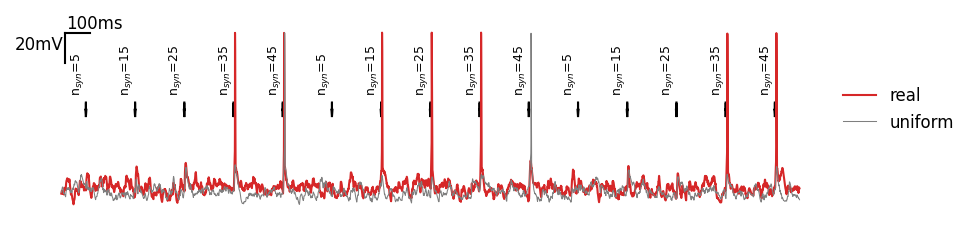

In [19]:
sim = Parallel(\
        filename='../../data/detailed_model/StimOnBg_simDemo_Basket.zip')
sim.load()
t0 = 100
show_Vm_trace(sim, iBranch=2, zoom=[t0,t0+3000],
              varied_key = 'from_uniform',
              plot = {'real':{'varied_key':False,
                              'color':'tab:red',
                                       'lw':1.0},
                      'uniform':{'varied_key':True,
                                 'color':'tab:grey',
                                 'lw':0.5}})

In [5]:
T, VMs, SPIKEs, RATEs = extract_trials(sim,
                                       loc='soma',
                                       varied_key = 'from_uniform',
                                       true_false_labels=['uniform', 'real'],
                                       pre=0, post=100)

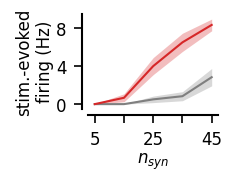

In [7]:
fig, ax = pt.figure()#figsize=(1.3,1.5))
for l, label, color in zip(range(2), ['uniform', 'real'], ['tab:grey', 'tab:red']):
    pt.plot(np.unique(sim.nCluster)[0],
            1e3*RATEs[label][:,:,:,:].mean(axis=(0,2,3)),
            sy=1e3*sem(RATEs[label][:,:,:,:].mean(axis=(2,3)), axis=0),
            color=color, ax=ax)
pt.set_plot(ax, xlabel='$n_{syn}$', 
            xticks=[5, 15, 25, 35, 45], xticks_labels=['5', '', '25', '', '45'],
            ylabel='stim.-evoked\nfiring (Hz)')
#ax.legend(loc=(1,0.4), frameon=False)

# Martinotti Cell

### Demo Simulation

```
python stim_on_background.py -c Martinotti --nCluster 5 15 25 35 45 --bgStimFreq 5e-4 --bgFreqInhFactor 1 --nStimRepeat 10 --test_NMDA --suffix Demo
```

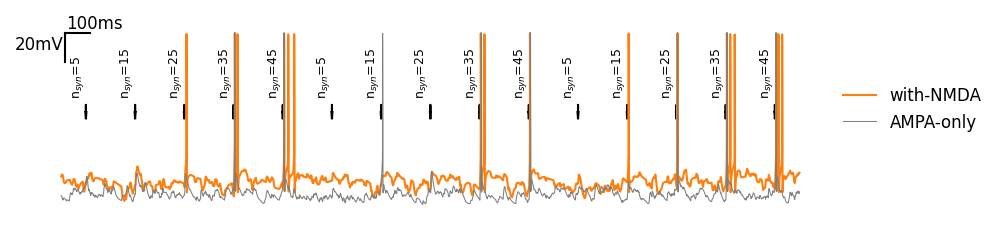

In [29]:
sim = Parallel(\
        filename='../../data/detailed_model/StimOnBg_simDemo_Martinotti.zip')
sim.load()
t0 = 3100
show_Vm_trace(sim, iBranch=1, zoom=[t0,t0+3000],
              varied_key = 'with_NMDA',
              plot = {'with-NMDA':{'varied_key':True,
                                       'color':'tab:orange',
                                       'lw':1.0},
                      'AMPA-only':{'varied_key':False,
                                   'color':'tab:grey',
                                   'lw':0.5}})

In [30]:
T, VMs, SPIKEs, RATEs = extract_trials(sim,
                                       loc='soma',
                                       varied_key = 'with_NMDA',
                                       true_false_labels=['with-NMDA', 'without'],
                                       pre=0, post=100)

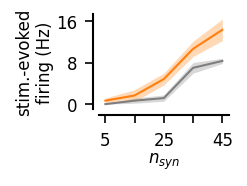

In [31]:
fig, ax = pt.figure()#figsize=(1.3,1.5))
for l, label, color in zip(range(2), ['without', 'with-NMDA'], ['tab:grey', 'tab:orange']):
    pt.plot(np.unique(sim.nCluster)[0],
            1e3*RATEs[label][:,:,:,:].mean(axis=(0,2,3)),
            sy=1e3*sem(RATEs[label][:,:,:,:].mean(axis=(2,3)), axis=0),
            color=color, ax=ax)
pt.set_plot(ax, xlabel='$n_{syn}$', 
            xticks=[5, 15, 25, 35, 45], xticks_labels=['5', '', '25', '', '45'],
            ylabel='stim.-evoked\nfiring (Hz)')

# Temporal Properties

## Vm

Simulation in the passive case:
```
# Basket Cell
python stim_on_background.py -c Basket --nCluster 35 --bgStimFreq 2e-3 --bgFreqInhFactor 1 --nStimRepeat 30 --test_uniform --suffix TimeCourse --ISI 300
# Martinotti Cell
python stim_on_background.py -c Martinotti --nCluster 35 --bgStimFreq 5e-4 --bgFreqInhFactor 1 --nStimRepeat 30 --test_NMDA --suffix TimeCourse --ISI 300
```

In [60]:
# load the two simulation data
simBasket = Parallel(\
        filename='../../data/detailed_model/StimOnBg_simPassive_Basket.zip')
simBasket.load()
T, VMsBasket, SpikesBasket, RATEsBasket = extract_trials(simBasket,
                                    loc='soma',
                                    varied_key = 'from_uniform',
                                    true_false_labels=['uniform', 'real'])
simMartinotti = Parallel(\
        filename='../../data/detailed_model/StimOnBg_simPassive_Martinotti.zip')
simMartinotti.load()
T, VMsMartinotti, SpikesMartinotti, RATEsMartinotti = extract_trials(simMartinotti,
                              loc='soma',
                              varied_key = 'with_NMDA',
                              true_false_labels=['with-NMDA', 'without'])

### Stimulus-Average $V_m$

#### Normalized to baseline and peak

(0.0, 30.0)

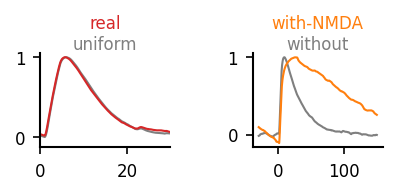

In [58]:
fig, AX = pt.figure(axes=(2, 1), figsize=(1,1))
for l, label, color in zip(range(2),
                           ['without', 'with-NMDA'],
                           ['tab:grey', 'tab:orange']):
    pt.annotate(AX[1], label+'\n'*l, (0.5, 1), ha='center', va='bottom',color=color)
    
    peak = np.max(VMsMartinotti[label].mean(axis=(0,1,2)))
    pre_cond = (T<0)
    baseline = np.mean(VMsMartinotti[label].mean(axis=(0,1,2))[pre_cond])
    NormVm = (VMsMartinotti[label].mean(axis=(0,1,2))-baseline)/(peak-baseline)
    pt.plot(T, NormVm, color=color, ax=AX[1])
for l, label, color in zip(range(2),
                           ['uniform', 'real'],
                           ['tab:grey', 'tab:red']):
    pt.annotate(AX[0], label+'\n'*l, (0.5, 1), ha='center', va='bottom',color=color)
    peak = np.max(VMsBasket[label].mean(axis=(0,1,2)))
    pre_cond = (T<0)
    baseline = np.mean(VMsBasket[label].mean(axis=(0,1,2))[pre_cond])
    NormVm = (VMsBasket[label].mean(axis=(0,1,2))-baseline)/(peak-baseline)
    pt.plot(T, NormVm, color=color, ax=AX[0])
    
AX[0].set_xlim([0, 30])

In [67]:
# load the two simulation data
simBasket = Parallel(\
        filename='../../data/detailed_model/StimOnBg_simTimeCourse_Basket.zip')
simBasket.load()
T, VMsBasket, SpikesBasket, RATEsBasket = extract_trials(simBasket,
                                    loc='soma',
                                    varied_key = 'from_uniform',
                                    true_false_labels=['uniform', 'real'])
simMartinotti = Parallel(\
        filename='../../data/detailed_model/StimOnBg_simTimeCourse_Martinotti.zip')
simMartinotti.load()
T, VMsMartinotti, SpikesMartinotti, RATEsMartinotti = extract_trials(simMartinotti,
                              loc='soma',
                              varied_key = 'with_NMDA',
                              true_false_labels=['with-NMDA', 'without'])

(0.0, 50.0)

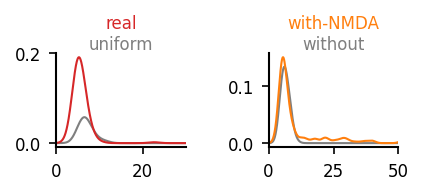

In [73]:
from scipy.ndimage import gaussian_filter1d

fig, AX = pt.figure(axes=(2, 1), figsize=(1,1))
for l, label, color in zip(range(2),
                           ['without', 'with-NMDA'],
                           ['tab:grey', 'tab:orange']):
    pt.annotate(AX[1], label+'\n'*l, (0.5, 1), ha='center', va='bottom',color=color)
    
    peak = np.max(RATEsMartinotti[label].mean(axis=(0,1,2)))
    pre_cond = (T<0)
    baseline = np.mean(RATEsMartinotti[label].mean(axis=(0,1,2))[pre_cond])
    Norm = (RATEsMartinotti[label].mean(axis=(0,1,2))-baseline)/(peak-baseline)
    pt.plot(T, gaussian_filter1d(Norm, 50), color=color, ax=AX[1])
for l, label, color in zip(range(2),
                           ['uniform', 'real'],
                           ['tab:grey', 'tab:red']):
    pt.annotate(AX[0], label+'\n'*l, (0.5, 1), ha='center', va='bottom',color=color)
    peak = np.max(RATEsBasket[label].mean(axis=(0,1,2)))
    pre_cond = (T<0)
    baseline = np.mean(RATEsBasket[label].mean(axis=(0,1,2))[pre_cond])
    Norm = (RATEsBasket[label].mean(axis=(0,1,2))-baseline)/(peak-baseline)
    pt.plot(T, gaussian_filter1d(Norm, 50), color=color, ax=AX[0])
    
AX[0].set_xlim([0, 30])
AX[1].set_xlim([0, 50])
#AX[1].set_yscale('log')

In [ ]:
fig, AX = pt.figure(axes=(2,VMs['real'].shape[0]), figsize=(2,2))
for iBranch in range(VMs['real'].shape[0]):
    for l, label, color in zip(range(2), ['uniform', 'real'], ['tab:grey', 'tab:red']):
        for c in range(VMs[label].shape[1]):
            print(c/(VMs[label].shape[1]-1))
            AX[iBranch][l].plot(T, VMs[label][iBranch,c,:,:].mean(axis=0),
                                color=pt.get_linear_colormap('lightgrey', color)(c/(VMs[label].shape[1]-1)))
            #for r in range(VMs[label].shape[2]):
            #    AX[iBranch][l].plot(T, VMs[label][iBranch,c,r,:],
            #                        color=pt.get_linear_colormap('lightgrey', color)(r/(VMs[label].shape[2]-1)))
            #    spikes = T[SPIKEs[label][iBranch,c,r,:]==1]
            #    AX[iBranch][l].plot(spikes, 0*spikes, 'o', ms=4)
        AX[iBranch][l].set_ylim([-70,-30])
#pt.set_common_ylims(AX)
#ax.legend(loc=(1,0.4), frameon=False)

In [ ]:
sim = Parallel(\
        filename='../../data/detailed_model/Basket_simpleStim_sim.zip')

loc = 'soma'

sim.load()
sim.fetch_quantity_on_grid('Vm_%s' % loc, dtype=object)

p = {}
for k in ['dt', 'nStimRepeat', 'ISI', 't0']:
    p[k] = sim.fetch_quantity_on_grid(k, dtype=float, return_last=True)
p['nCluster'] = sim.fetch_quantity_on_grid('nCluster', dtype=object, return_last=True)
print(p['nCluster'])

params = dict(iBranch=0)

fig, ax = pt.figure(figsize=(3,2), left=0.2, bottom=0.5)

for l, label in enumerate(['real', 'uniform']):
    Vm = sim.get('Vm_%s' % loc, dict(from_uniform=(label=='uniform'), **params))[0]
    ax.plot(np.arange(len(Vm))*p['dt'], Vm, label=label)

for r in range(int(p['nStimRepeat'])):
    for c, nC in enumerate(p['nCluster']):
        pt.arrow(ax, [p['t0']+r*p['ISI']+c*p['nStimRepeat']*p['ISI'], 0, 0, -10],
                 head_width=2, head_length=5, width=0.1)

ax.legend(loc=(1,0.4), frameon=False)



In [ ]:
def trial_alignement(Vm, p, 
                     pre=-30, post=200):
    
    t = np.arange(len(Vm))*p['dt']
    T = np.arange(int(pre/p['dt']), int(post/p['dt']))*p['dt']
    X = []
    for c, nC in enumerate(p['nCluster']):
        X.append([])
        for r in range(int(p['nStimRepeat'])):
            tstart = p['t0']+r*len(p['nCluster'])*p['ISI']+c*p['ISI']
            cond = t>=(tstart+T[0])
            X[c].append(Vm[cond][:len(T)])
        
    return T, np.array(X)


fig, AX = pt.figure(axes=(2,1), figsize=(2,2))
for l, label, color in zip(range(2), ['real', 'uniform'], ['tab:grey', 'tab:orange']):
    Vm = sim.get('Vm_%s' % loc, dict(from_uniform=(label=='uniform'), **params))[0]
    T, X = trial_alignement(Vm, p)
    for c, nC in enumerate(p['nCluster']):
        for r, x in enumerate(X[c]):
            AX[l].plot(T, x, color=plt.cm.tab10(c))
        #AX[l].plot(T, X[c].mean(axis=0), color=color)

pt.set_common_ylims(AX)
#ax.legend(loc=(1,0.4), frameon=False)

# Calibration of the Background Activity Setting

Generate the simulation data with:
    
```
python stim_on_background.py --background_calib
```

In [10]:
# load data

sim = Parallel(\
        filename='../../data/detailed_model/StimOnBg_BgCalib.zip')

loc = 'soma'

sim.load()
sim.fetch_quantity_on_grid('Vm_soma', dtype=object) 
sim.fetch_quantity_on_grid('output_rate', dtype=object) 

KeyError: "There is no item named 'scan.npy' in the archive"

In [ ]:
sim.keys

In [ ]:
def show_Vm_trace(sim, 
                  cellType='Basket', iBranch=0, ibgStimFreq=0, ibgFreqInhFactor=0,
                  loc='soma',
                  color='k',
                  zoom=None):
    
    sim.fetch_quantity_on_grid('Vm_%s' % loc, dtype=object) 
    p = load_params_from(sim)
    
    params = dict(iBranch=iBranch, cellType=cellType,
                  bgStimFreq=np.unique(sim.bgStimFreq)[ibgStimFreq],
                  bgFreqInhFactor=np.unique(sim.bgFreqInhFactor)[ibgFreqInhFactor])

    fig, ax = pt.figure(figsize=(2.5,2), left=0.2, bottom=0.5)

    Vm = sim.get('Vm_%s' % loc, params)[0]
    t = np.arange(len(Vm))*p['dt']
    if zoom is not None:
        Vm = Vm[(t>zoom[0]) & (t<zoom[1])]
        t = t[(t>zoom[0]) & (t<zoom[1])]
    else:
        zoom=[t[0], t[-1]]
    ax.plot(t, Vm, color='k', lw=1)

    for r in range(int(p['nStimRepeat'])):
        for c, nC in enumerate(p['nCluster']):
            tstart = p['t0']+r*len(p['nCluster'])*p['ISI']+c*p['ISI']
            if (tstart>zoom[0]) and (tstart<zoom[1]):
                pt.arrow(ax, [tstart, 0, 0, -10],
                         head_width=4, head_length=5, width=0.1)
                pt.annotate(ax, 'n$_{syn}$=%i' % nC, (tstart, 5), 
                            rotation=90, xycoords='data', fontsize=6, ha='center')
            
    ax.axis('off')
    ax.legend(loc=(1,0.4), frameon=False)
    pt.draw_bar_scales(ax, Xbar=50, Xbar_label='50ms', Ybar=20, Ybar_label='20mV')
    
show_Vm_trace(sim, iBranch=0)

In [ ]:
show_Vm_trace(sim, cellType='Basket', iBranch=0, ibgStimFreq=0, ibgFreqInhFactor=0)

In [ ]:
fig = show_Vm_trace(sim, cellType='Basket', iBranch=1, ibgStimFreq=1, ibgFreqInhFactor=0, zoom=[400,1600])
plt.savefig('fig.svg')